In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка данных и проверка структуры

In [4]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'

In [288]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [289]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [290]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [291]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [292]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [293]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


# 2. Разведывательный анализ данных

In [294]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\админ\AppData\Local\Temp\ipykernel_3484\447817491.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [295]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [296]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2.1 Общий анализ данных

In [297]:
# Количество уникальных значений
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

## 2.2 Взаимосвязи между признаками

C:\Users\админ\AppData\Local\Temp\ipykernel_3484\3473321685.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

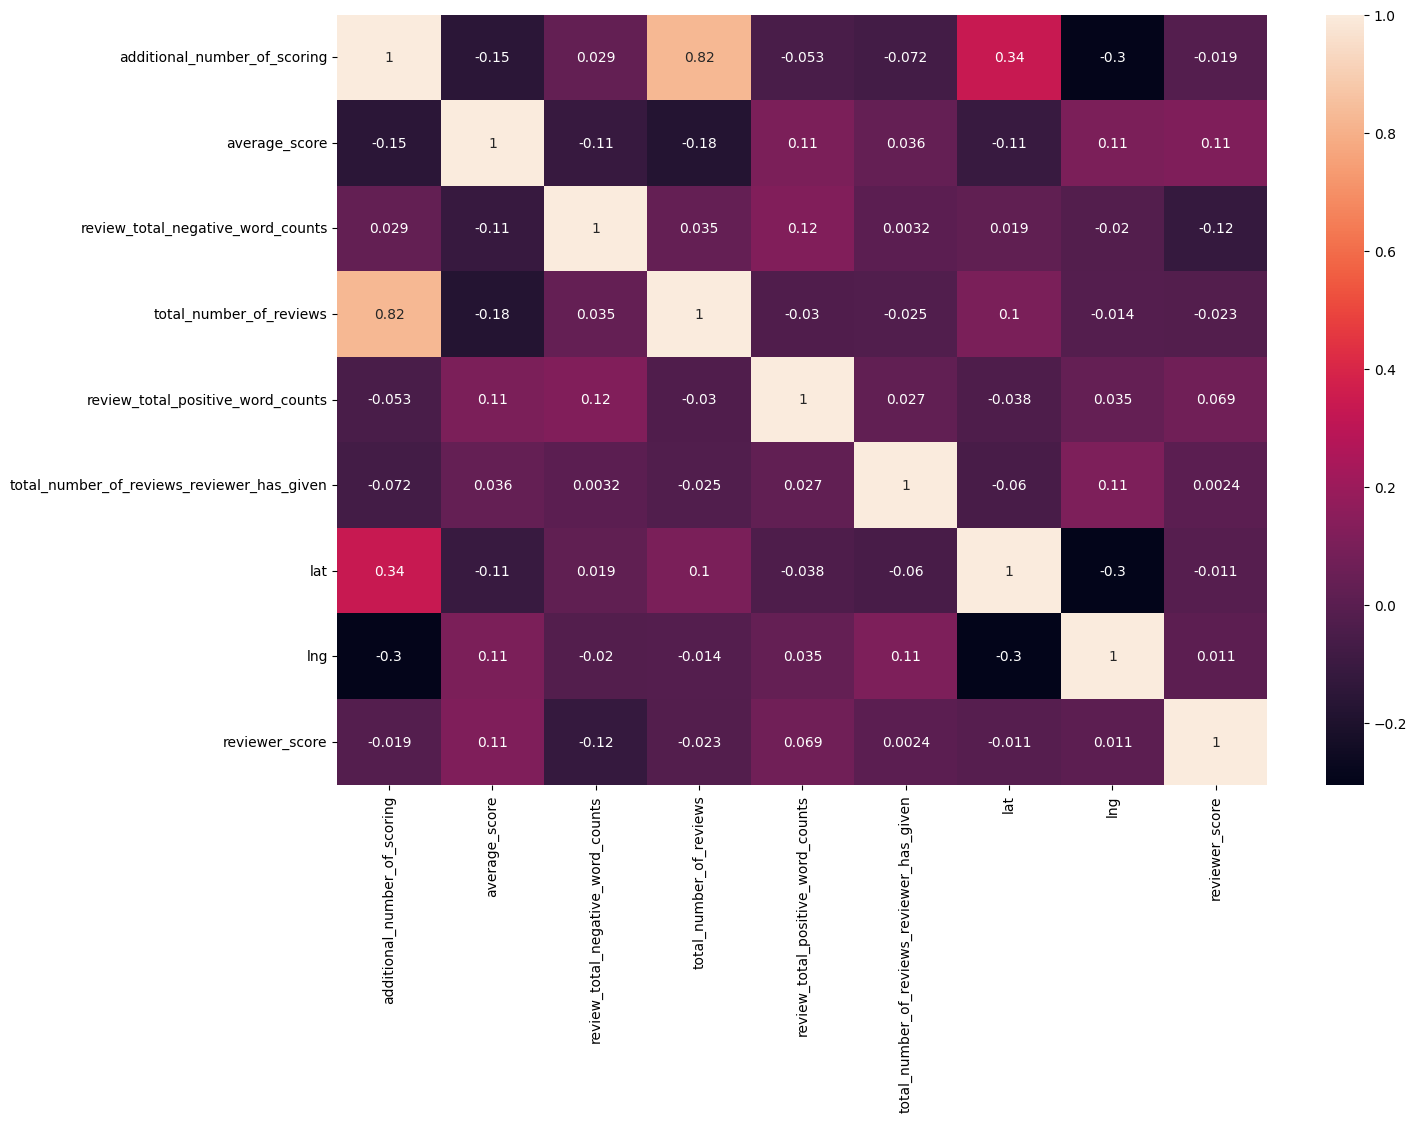

In [298]:
# построим тепловую карту корреляции
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Между признаками Total_number_of_reviews и Additional_number_of_scoring сильная корреляция, один из этих признаков можно удалить
Все признаки имеют слабую связь с целевой переменной reviewer_scorе

## 2.3 Создание и преобразование признаков

In [299]:
# Выделение города и страны из адреса
def find_city_country(adr):
    # страна United Kindom состоит из двух слов, поэтому заменим их на одно: 'UK'
    adr = adr.replace('United Kingdom', 'UK') 
    # выделим в адресе только слова
    adr_list = [word for word in adr.split(' ') if word.isalpha()] 
    # вернём название города и страны
    return (adr_list[len(adr_list)-2], adr_list[len(adr_list)-1]) # вернём кортеж (город, страна)

# Создадим новый признак 'hotel_city' название города
data['hotel_city'] = data['hotel_address'].apply(lambda x: find_city_country(x)[0])
display(data['hotel_city'].value_counts())

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [300]:
# Создадим новый признак 'hotel_country' название города
data['hotel_country']=data['hotel_address'].apply(lambda x: find_city_country(x)[1])
data['hotel_country'].value_counts()

UK             262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: hotel_country, dtype: int64

### Посмотрим зависимость рейтинга от города и страны

In [301]:
# Произведем группировку, посчитаем количество проставленных оценок и среднюю оценку
grouped = data.groupby('hotel_city', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
display(grouped)

,hotel_city,count,mean_score
0,Amsterdam,57214,6.351014
1,Barcelona,60149,6.418190
2,London,262301,6.246694
3,Milan,37207,6.261615
4,Paris,59928,6.299141
5,Vienna,38939,6.408716


Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от города')

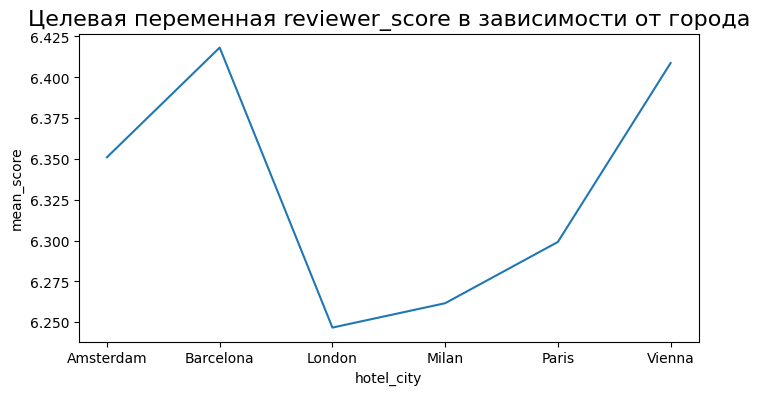

In [302]:
# Построим линейный график

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='hotel_city', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от города', fontdict={'fontsize':16})

In [303]:
grouped = data.groupby('hotel_country', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
display(grouped)

,hotel_country,count,mean_score
0,Austria,38939,6.408716
1,France,59928,6.299141
2,Italy,37207,6.261615
3,Netherlands,57214,6.351014
4,Spain,60149,6.418190
5,UK,262301,6.246694


Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от страны')

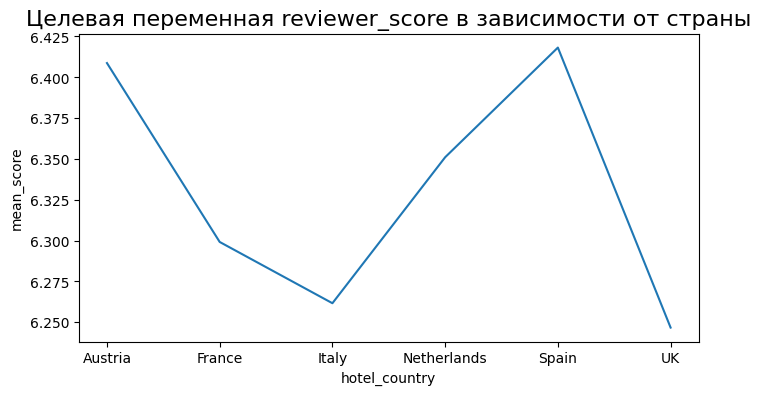

In [304]:
# Построим линейный график

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='hotel_country', y='mean_score', markers=True)
fig.set_title('Целевая переменная reviewer_score в зависимости от страны', fontdict={'fontsize':16})

In [305]:
# посмотрим какое количество оценок было проставлено в каждой стране

#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='hotel_country', #ось x
    y='count', #ось y
    color='hotel_country', #расцветка в зависимости от страны
    text = 'count', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Зависимоть количества оценок от страны' #заголовок
)
#отображаем его
fig.show()

???? 
Информация о городе поможет заполнить пропуски в географических координатах

Средние оценки путешественников немного отличаются в зависимости от города. Если округлить до одного знака после запятой, разница максимум 2 пункта 6.2 - 6.4

### Работа с датой

Text(0.5, 1.0, 'Распределение отзывов по дням недели')

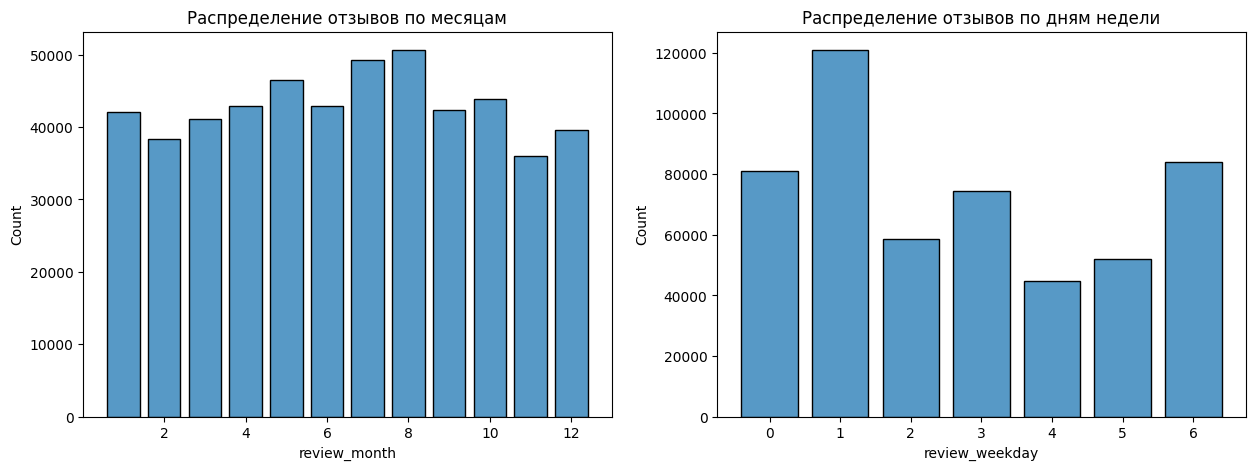

In [306]:
#Выделим признаки месяц и день недели
# преобразуем тип object в дату
data['review_date'] = pd.to_datetime(data['review_date']) 
# выделим месяц
data['review_month'] = data['review_date'].dt.month 
# выделим день недели
data['review_weekday'] = data['review_date'].dt.dayofweek 

# Посмотрим на распределение количествава отзывов по месяцам и зависимость оценок от дня недели и месяца
# Графики распределения отзывов
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.histplot(data=data, x='review_month', discrete=True, shrink=.8, ax=ax[0])
sns.histplot(data=data, x='review_weekday', discrete=True, shrink=.8, ax=ax[1])
ax[0].set_title('Распределение отзывов по месяцам', fontdict={'size': 12})
ax[1].set_title('Распределение отзывов по дням недели', fontdict={'size': 12})

Наибольшее количество отзывов приходится на январь, май, июль и август. В общем на сезон отпусков.
Большое количествво отзывов было в воскресенье, понедельник, вторник.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от месяца отзыва')

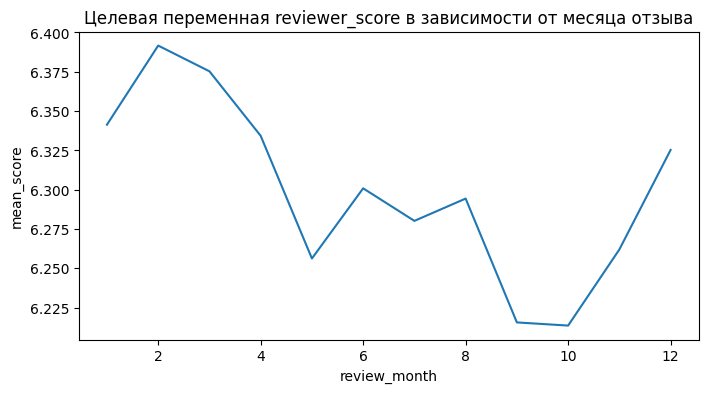

In [307]:
# Зависимость средних оценок от месяца выставления оценки
grouped = data.groupby('review_month', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='review_month', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от месяца отзыва', fontdict={'fontsize':12})

Средние оценки отличаются по временам года: наибольшие - зимой, чуть ниже - весной, далее - лето, минимальные - осенью. Разница между наибольшей и наименьшей средней оценкой сотавляет 0.2 балла.


In [308]:
#Выделим признак время года
def season(mth):
    if mth in range (3,6):
        return 'spring'
    elif mth in range (6,9):
        return 'summer'
    elif mth in range (9,12):
        return 'autumn'
    else:
        return 'winter'

data['review_season'] = data['review_month'].apply(season) # новый признак

data['review_season'].value_counts(normalize=True) # распределение отзывов по временам года

summer    0.277052
spring    0.253002
autumn    0.237022
winter    0.232924
Name: review_season, dtype: float64

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от дня недели')

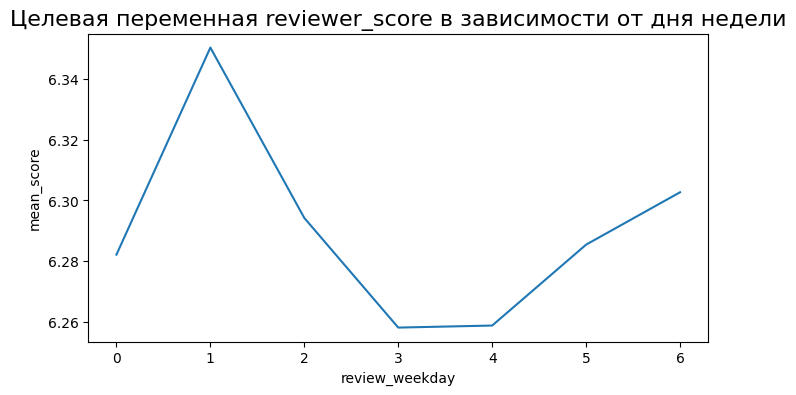

In [309]:
# Зависимость средних оценок от дня недели выставления оценки

grouped = data.groupby('review_weekday', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='review_weekday', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от дня недели', fontdict={'fontsize':16})

Работа с национальностью ревьера

In [310]:
# Посмотрим какими национальностями предтавлены большинство путешесвенников 
data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)

 United Kingdom               0.475524
 United States of America     0.068711
 Australia                    0.042048
 Ireland                      0.028749
 United Arab Emirates         0.019845
 Saudi Arabia                 0.017356
 Netherlands                  0.017009
 Switzerland                  0.016826
 Germany                      0.015397
 Canada                       0.015306
 France                       0.014147
 Israel                       0.012817
 Italy                        0.011855
 Belgium                      0.011694
 Turkey                       0.010556
Name: reviewer_nationality, dtype: float64

По  количеству отзывов наибольшее число составляют англичане,  далее идут американцы, австралийцы и ирландцы. Эти 4 национальности составляют топ-4 среди наших путешественников. У них наибольшее количество отзывов. Количество отзывов остальных путешенников не сильно отличется между собой.

In [311]:
# Оставим 4 национальности, остальные назовем 'other'
top_4 = data['reviewer_nationality'].value_counts(normalize=True).nlargest(4).index # список стран топ-15 по кол-ву отзывов
def nat_group(nat):
    if nat in top_4:
        return nat[1:len(nat)-1] # Уберём первый и последний символ - пробелы
    else:
        return 'Other'

# Создадим соответствующий признак
data['reviewer_nat_group'] = data['reviewer_nationality'].apply(lambda x: nat_group(x))

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от национальности')

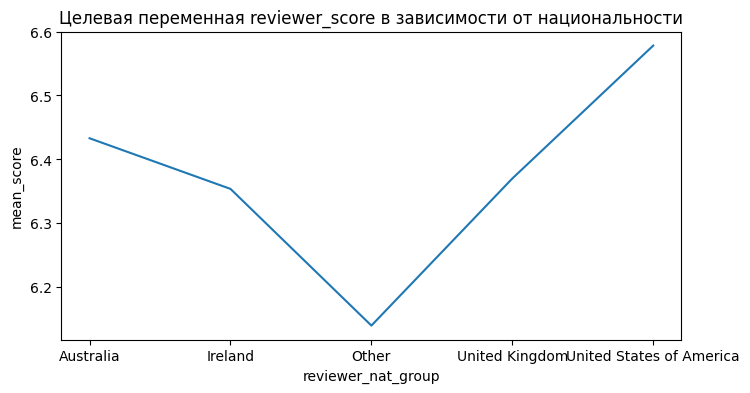

In [312]:
# Посмотрим на оценки в зависимости от национальностей
grouped = data.groupby('reviewer_nat_group', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))
fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='reviewer_nat_group', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от национальности', fontdict={'fontsize':12})

Путешественники из Австралии и США ставят отелям оценки выше, чем остальные. Минимальные оценки в группе Other. Отличие минимальной и максимальной оценок составляет окло 0.4 баллов.

Работа с отзывами

In [313]:
# Всего слов в отзывах каждого пользователя
data['total_words'] = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']
# Доли положительных и отрицательных частей
data['positive_rate'] = round(data['review_total_positive_word_counts'] / data['total_words'] * 100)
data['negative_rate'] = round(data['review_total_negative_word_counts'] / data['total_words'] * 100)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


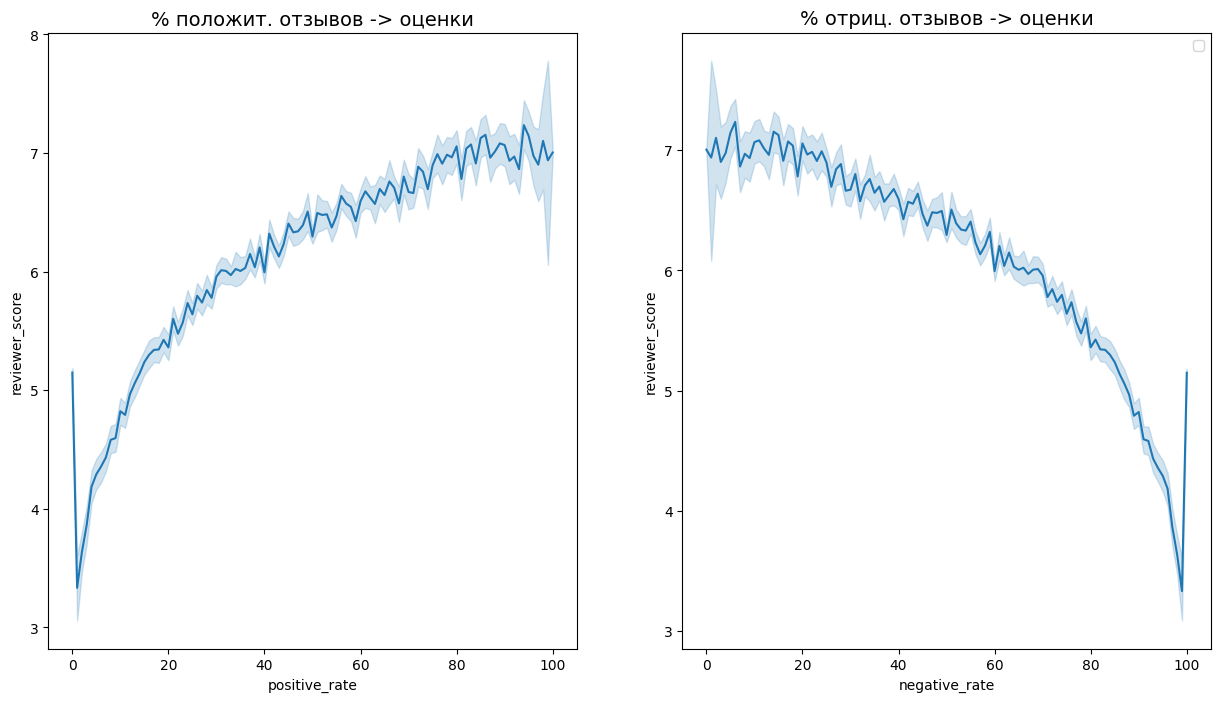

In [314]:
# Завиимость оценок от доли положительных и отрицательных отзывов
fig, (ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax1[0].set_title('% положит. отзывов -> оценки', fontdict={'fontsize': 14})
ax1[1].set_title('% отриц. отзывов -> оценки', fontdict={'fontsize': 14})

sns.lineplot(data=data, x='positive_rate', y='reviewer_score', ax=ax1[0])
sns.lineplot(data=data, x='negative_rate', y='reviewer_score', ax=ax1[1])
plt.legend()

Наблюдается плавный рост оценки с увеличением доли положительных отзывов.

И чем выше доля, тем шире 95% доверительный интервал вокруг среднего значения (область более бледного цвета вокруг тёмной линии на графике)

Начало графика игнорируем, так как у нас в данных есть строки с оценкой, равной нулю - блок тестовых данных

In [315]:
# Пропуски

data[data['negative_rate'].isnull()]['positive_review'].value_counts()

No Positive    127
Name: positive_review, dtype: int64

In [316]:
# Интерпретируем пропуски как 100% негативные отзывы, заполним их соответствующими значениями

values = {'positive_rate': 0.0, 'negative_rate': 100.0}
data = data.fillna(values)

In [317]:
# Разберём положительные отзывы, выясним за что больше всего путешественники хвалят отели
# Возможно получится выделить несколько пунктов и создать соответствующие бинарные признаки

positive_reviews = data['positive_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=positive_reviews)
df_rev.to_csv('positive_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Bed, location, staff, breakfast, clean, room - путешественники часто отмечают это в положительных отзывах
# Создадим бинарные признаки. 1, если этот момент отмечен в отзыве, 0 - не отмечен

data['positive_bed'] = data['positive_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['positive_location'] = data['positive_review'].apply(lambda x: 1 if 'location' in x.lower() else 0)
data['positive_staff'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['positive_breakfast'] = data['positive_review'].apply(lambda x: 1 if 'breakfast' in x.lower() else 0)
data['positive_room'] = data['positive_review'].apply(lambda x: 1 if 'room' in x.lower() else 0)

In [318]:
# Аналогично поработаем с негативными отзывами

negative_reviews = data['negative_review'].value_counts(normalize=True)
df_rev = pd.DataFrame(data=negative_reviews)
df_rev.to_csv('negative_reviews.csv') # сохраним, чтобы просмотреть все отзывы

# Nois, bed, breakfast, bath or shower, clean, dirt, internet or wi fi or wifi, room, staff or reception, charge or expensive or price or cost, tired or old, 
# Найдём наиболее часто встречающиеся слова в тексте и создадим соответствующие признаки:
# 1, если путешественник жаловался на эту вещь, 0 - если нет

data['negative_meal'] = data['negative_review'].apply(lambda x: 1 if 'breakfast' in x.lower()
                                                      or 'meal' in x.lower() or 'dinner' in x.lower() else 0)
data['negative_bed'] = data['negative_review'].apply(lambda x: 1 if 'bed' in x.lower() else 0)
data['negative_bath'] = data['negative_review'].apply(lambda x: 1 if 'bath' in x.lower() or 'shower' in x.lower() else 0)
data['negative_wifi'] = data['negative_review'].apply(lambda x: 1 if 'internet' in x.lower() or 'wifi' in x.lower()
                                                      or 'wi fi' in x.lower() or 'wi-fi' in x.lower() else 0)
data['negative_staff'] = data['negative_review'].apply(lambda x: 1 if 'staff' in x.lower() or 'reception' in x.lower() else 0)
data['negative_price'] = data['negative_review'].apply(lambda x: 1 if 'charge' in x.lower() or 'price' in x.lower()
                                                       or 'expensive' in x.lower() or 'cost' in x.lower()
                                                       or 'euro' in x.lower() or 'pound' in x.lower()
                                                       or 'pricey' in x.lower() or 'pricy' in x.lower() else 0)
data['negative_old'] = data['negative_review'].apply(lambda x: 1 if 'old' in x.lower() or 'tired' in x.lower()
                                                     or 'renovation' in x.lower() else 0)
data['negative_location'] = data['negative_review'].apply(lambda x: 1 if 'far away' in x.lower() or 'bit of walk' in x.lower()
                                                          or 'walk from' in x.lower() or 'out of the way' in x.lower()
                                                          or 'far from' in x.lower() else 0)
data['negative_clean'] = data['negative_review'].apply(lambda x: 1 if 'clean' in x.lower() or 'dirt' in x.lower() else 0)


Работа с тегами

In [319]:
# Проанализируем теги
tags = data['tags'].value_counts(normalize=True)
df_tags = pd.DataFrame(data=tags)
# сохраним, чтобы просмотреть все теги
df_tags.to_csv('tags.csv') 

# Цель путешествия
def trip_purp(tags_text): 
    if 'Business' in tags_text:
        return 'Business'
    elif 'Leisure' in tags_text:
        return 'Leisure'
    else:
        return 'Unknown'
    
# Состав путешественников
def who_travels(tags_text):
    if 'Solo' in tags_text:
        return 'Solo'
    elif 'Couple' in tags_text:
        return 'Couple'
    elif 'Family' in tags_text:
        return 'Family'
    elif 'friends' in tags_text:
        return 'Friends'
    elif 'pet' in tags_text:
        return 'With a pet'
    elif 'Group' in tags_text:
        return 'Group'
    else:
        return 'Other'
    
# Длительность путешествия
def trip_duration(tags_text):
    # Индекс нужного нам тега не всегда одинаков, так как некоторые теги могут быть пропущены
    days = tags_text.find('Stayed')
    if days > 0:
        # если нашли такой тег, возвращаем следом идущее кол-во дней, максимум двузначное
        return int(tags_text[days+6:days+9])
    # если не нашли нужный тег
    return -1 

# Создадим новые признаки
 # цель путешествия
data['trip_purpose'] = data['tags'].apply(trip_purp)
# кто путешествует
data['who_trip'] = data['tags'].apply(who_travels) 
# длительность путешествия в днях
data['trip_time'] = data['tags'].apply(trip_duration) 

Text(0.5, 1.0, 'Распределение количества дней пребывания в отеле')

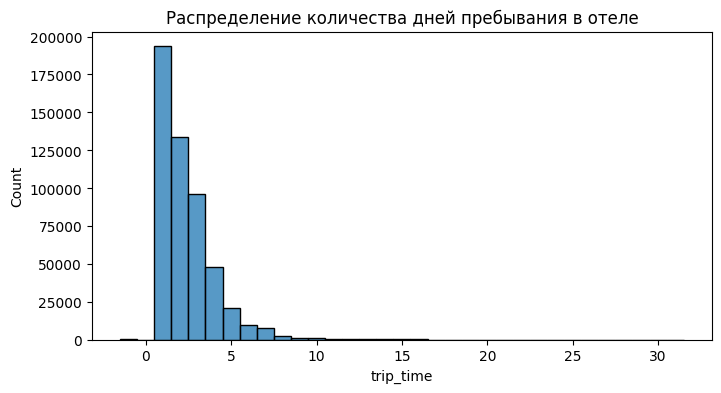

In [320]:
# График распределения
fig = plt.figure(figsize=(8, 4))
fig = sns.histplot(data=data, x='trip_time', discrete=True)
fig.set_title('Распределение количества дней пребывания в отеле', fontdict={'size': 12})

Большинство путешественников останавливаются в отеле на один-два дня, редко кто останавливается в отеле больше 5 дней.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в завис. от длительности поездки')

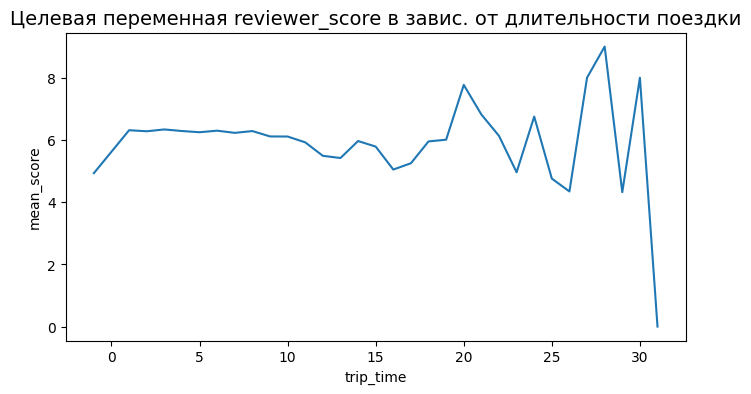

In [321]:
# Зависимость целевой переменной от продолжительности путешествия
grouped = data.groupby('trip_time', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='trip_time', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в завис. от длительности поездки', fontdict={'fontsize':14})

Видно, что с увеличением продолжительности поездки растёт разброс средних оценок, и при этом график распределения показывает, что количество путешественников при этом снижается.

Изменим признак, создадим две группы - продолжительность поездки до 5 дней и свыше 5 дней. 

In [322]:
# преобразуем признак в бинарный
data['trip_time_bin'] = data['trip_time'].apply(lambda x: 1 if x<=5 else 0)

data.groupby('trip_time_bin').agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

,count,mean_score
trip_time_bin,,
0,23481,6.219394
1,492257,6.301406


### 2.3.3 Заполнение пропусков

In [323]:
# Признаки с пропусками - долгота и широта - можно заполнить на основании созданного признака hotel_city
# Оценим, как пропуски распределены по городам

data[data['lat'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count'))

,hotel_city,qty
0,Barcelona,207
1,Paris,382
2,Vienna,2679


In [324]:
# Рассчитаем средние значения широты и долготы для каждого города
data.groupby('hotel_city', as_index=False).agg(mean_lat=('lat', 'mean'), mean_lng=('lng', 'mean'))

,hotel_city,mean_lat,mean_lng
0,Amsterdam,52.362206,4.885409
1,Barcelona,41.389079,2.169147
2,London,51.510739,-0.138960
3,Milan,45.479617,9.191835
4,Paris,48.863715,2.326780
5,Vienna,48.203362,16.367234


In [325]:
# Заполним пропуски средними значениями для каждого города
data.loc[(data['hotel_city']=='Barcelona') & (data['lat'].isnull()), 'lat'] = 41.389079
data.loc[(data['hotel_city']=='Barcelona') & (data['lng'].isnull()), 'lng'] = 2.169147

data.loc[(data['hotel_city']=='Paris') & (data['lat'].isnull()), 'lat'] = 48.863715
data.loc[(data['hotel_city']=='Paris') & (data['lng'].isnull()), 'lng'] = 2.326780

data.loc[(data['hotel_city']=='Vienna') & (data['lat'].isnull()), 'lat'] = 48.203362
data.loc[(data['hotel_city']=='Vienna') & (data['lng'].isnull()), 'lng'] = 16.367234

Скорее всего эти признаки придется в последствии удалить.

### 2.3.4 Кодирование категориальных признаков

In [326]:
# проверим структуру
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [327]:
data.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1475
lng                                             1475
sample                                             2
reviewer_score                                    38
hotel_city                                    

In [328]:
# Кодирование OneHotEncoding для признаков, содержащих менее 10 уникальных значений
# импорт для работы с кодировщиком
import category_encoders as ce

# hotel_city - 6 значений
encoder = ce.OneHotEncoder(cols=['hotel_city']) 
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

# hotel_country - 6 значений
encoder = ce.OneHotEncoder(cols=['hotel_country']) 
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

# trip_purposr - 3 значения
encoder = ce.OneHotEncoder(cols=['trip_purpose']) 
type_bin = encoder.fit_transform(data['trip_purpose'])
data = pd.concat([data, type_bin], axis=1)

# who_trip - 6 значений
encoder = ce.OneHotEncoder(cols=['who_trip']) 
type_bin = encoder.fit_transform(data['who_trip'])
data = pd.concat([data, type_bin], axis=1)

# reviewer_nat_group - 5 значений
encoder = ce.OneHotEncoder(cols=['reviewer_nat_group']) 
type_bin = encoder.fit_transform(data['reviewer_nat_group'])
data = pd.concat([data, type_bin], axis=1)

# review_weekday - 7 значений
encoder = ce.OneHotEncoder(cols=['review_weekday']) 
type_bin = encoder.fit_transform(data['review_weekday'])
data = pd.concat([data, type_bin], axis=1)

# review_season - 4 значения
encoder = ce.OneHotEncoder(cols=['review_season']) # времена года - 4 значения
type_bin = encoder.fit_transform(data['review_season'])
data = pd.concat([data, type_bin], axis=1)

In [329]:
# Двоичное кодирование для признаков, содержащих более 10 значений
# указываем столбец для кодирования
#bin_encoder = ce.BinaryEncoder(cols=['review_month']) 
#type_bin = bin_encoder.fit_transform(data['review_month'])
#data = pd.concat([data, type_bin], axis=1)

# Удаление текстовых и закодированных категориальных признаков
cols_to_del = ['additional_number_of_scoring', # корреляция с другим признаком
                'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', # текстовые
                'negative_review', 'positive_review', 'tags', 'days_since_review',
                'hotel_city', 'hotel_country','review_weekday', 'review_month', # категориальные
                'review_season', 'reviewer_nat_group', 'trip_purpose', 'who_trip', 'trip_time'
                ]


data = data.drop(cols_to_del, axis=1)

### 2.3.5 Преобразование числовых признаков

In [330]:
# проверим структуру
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   total_words                                 515738 non-null  int64  
 

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от количества прошлых отзывов')

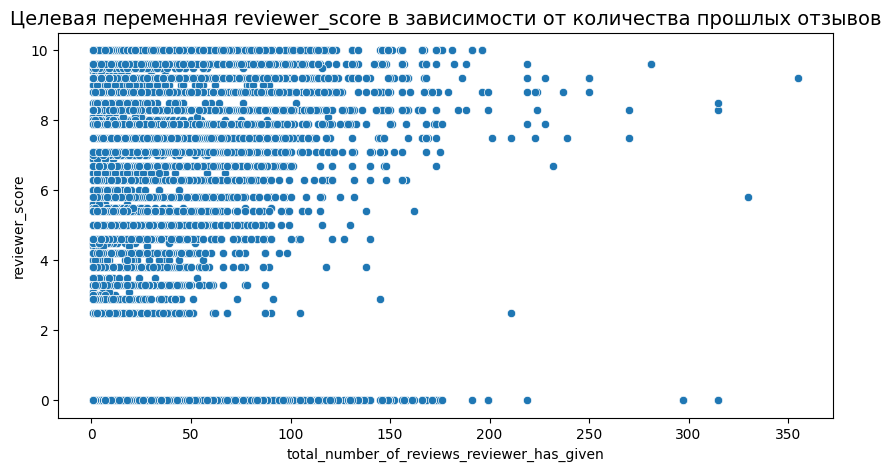

In [331]:
# Зависимость оценки от продолжительности путешествия
fig = plt.figure(figsize=(10, 5))
fig = sns.scatterplot(data=data, x='total_number_of_reviews_reviewer_has_given', y='reviewer_score')
fig.set_title('Целевая переменная reviewer_score в зависимости от количества прошлых отзывов', fontdict={'fontsize':14})

На графике видно, что отели с низкими прошлыми оценками до 4 чаще всего имеют количество прошлых отзывов до 50, с оценками 4-8 - до 150,
а те отели, у которых самое большое количество прошлых отзывов, имеют высокие оценки 8-10.
Есть отдельные точки, которые можно определить как выбросы.

Text(0.5, 1.0, 'Целевая переменная reviewer_score в зависимости от текущей средней оценки')

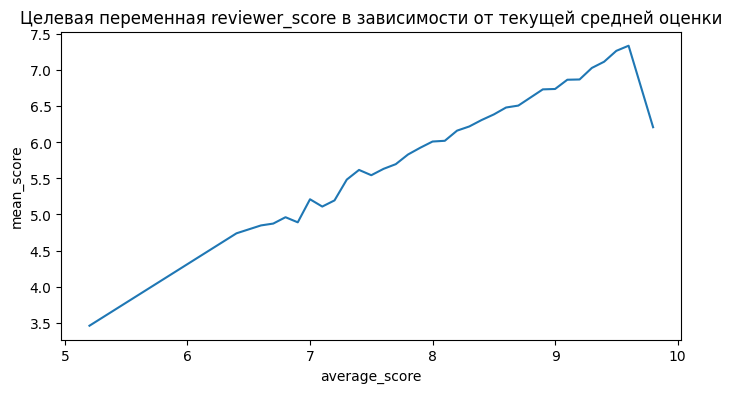

In [332]:
# Зависимость оценки от текущей средней оценки отеля
# Сгруппируем данные по средним оценкам
grouped = data.groupby('average_score', as_index=False).agg(count=('reviewer_score', 'count'), mean_score=('reviewer_score', 'mean'))

fig = plt.figure(figsize=(8, 4))
fig = sns.lineplot(data=grouped, x='average_score', y='mean_score', markers=True, dashes=False)
fig.set_title('Целевая переменная reviewer_score в зависимости от текущей средней оценки', fontdict={'fontsize':12})

График показывает прямую зависимость оценки пользователя от текущей средней оценки для данного отеля, только зависимость в интервале  9.5 - 10 - обратная.

In [333]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   total_words                                 515738 non-null  int64  
 

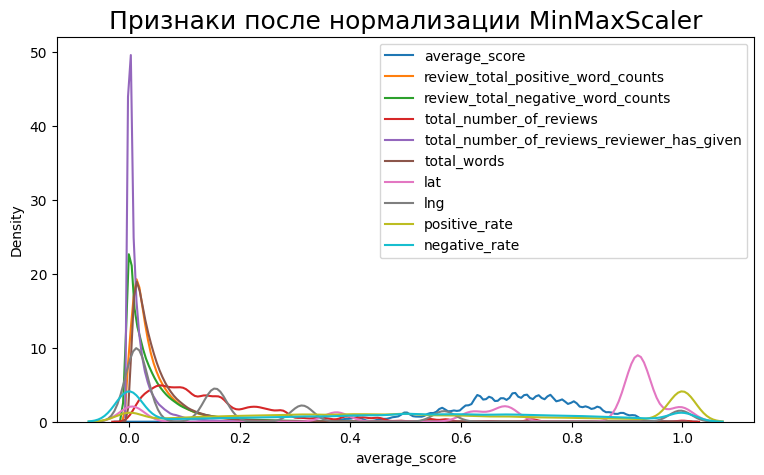

In [336]:
# Нормализация числовых признаков
from sklearn import preprocessing

# числовые признаки для нормализации
cols_num = ['average_score', 'review_total_positive_word_counts', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'total_words',
            'lat', 'lng', 'positive_rate', 'negative_rate'] # числовые признаки для нормализации
mm_scaler = preprocessing.MinMaxScaler()
# скопируем эти данные
data_num = data[cols_num].copy() 

data_num_mm = mm_scaler.fit_transform(data_num)
data_num_mm = pd.DataFrame(data_num_mm, columns=cols_num)

# Визуализация
fig, (ax1) = plt.subplots(ncols=1, figsize=(9, 5))
ax1.set_title('Признаки после нормализации MinMaxScaler', fontdict={'fontsize': 18})

for col in cols_num:
    sns.kdeplot(data_num_mm[col], ax=ax1)

plt.legend(cols_num)

## 2.4 Анализ мультиколлинеарности и отбор признаков

<AxesSubplot: >

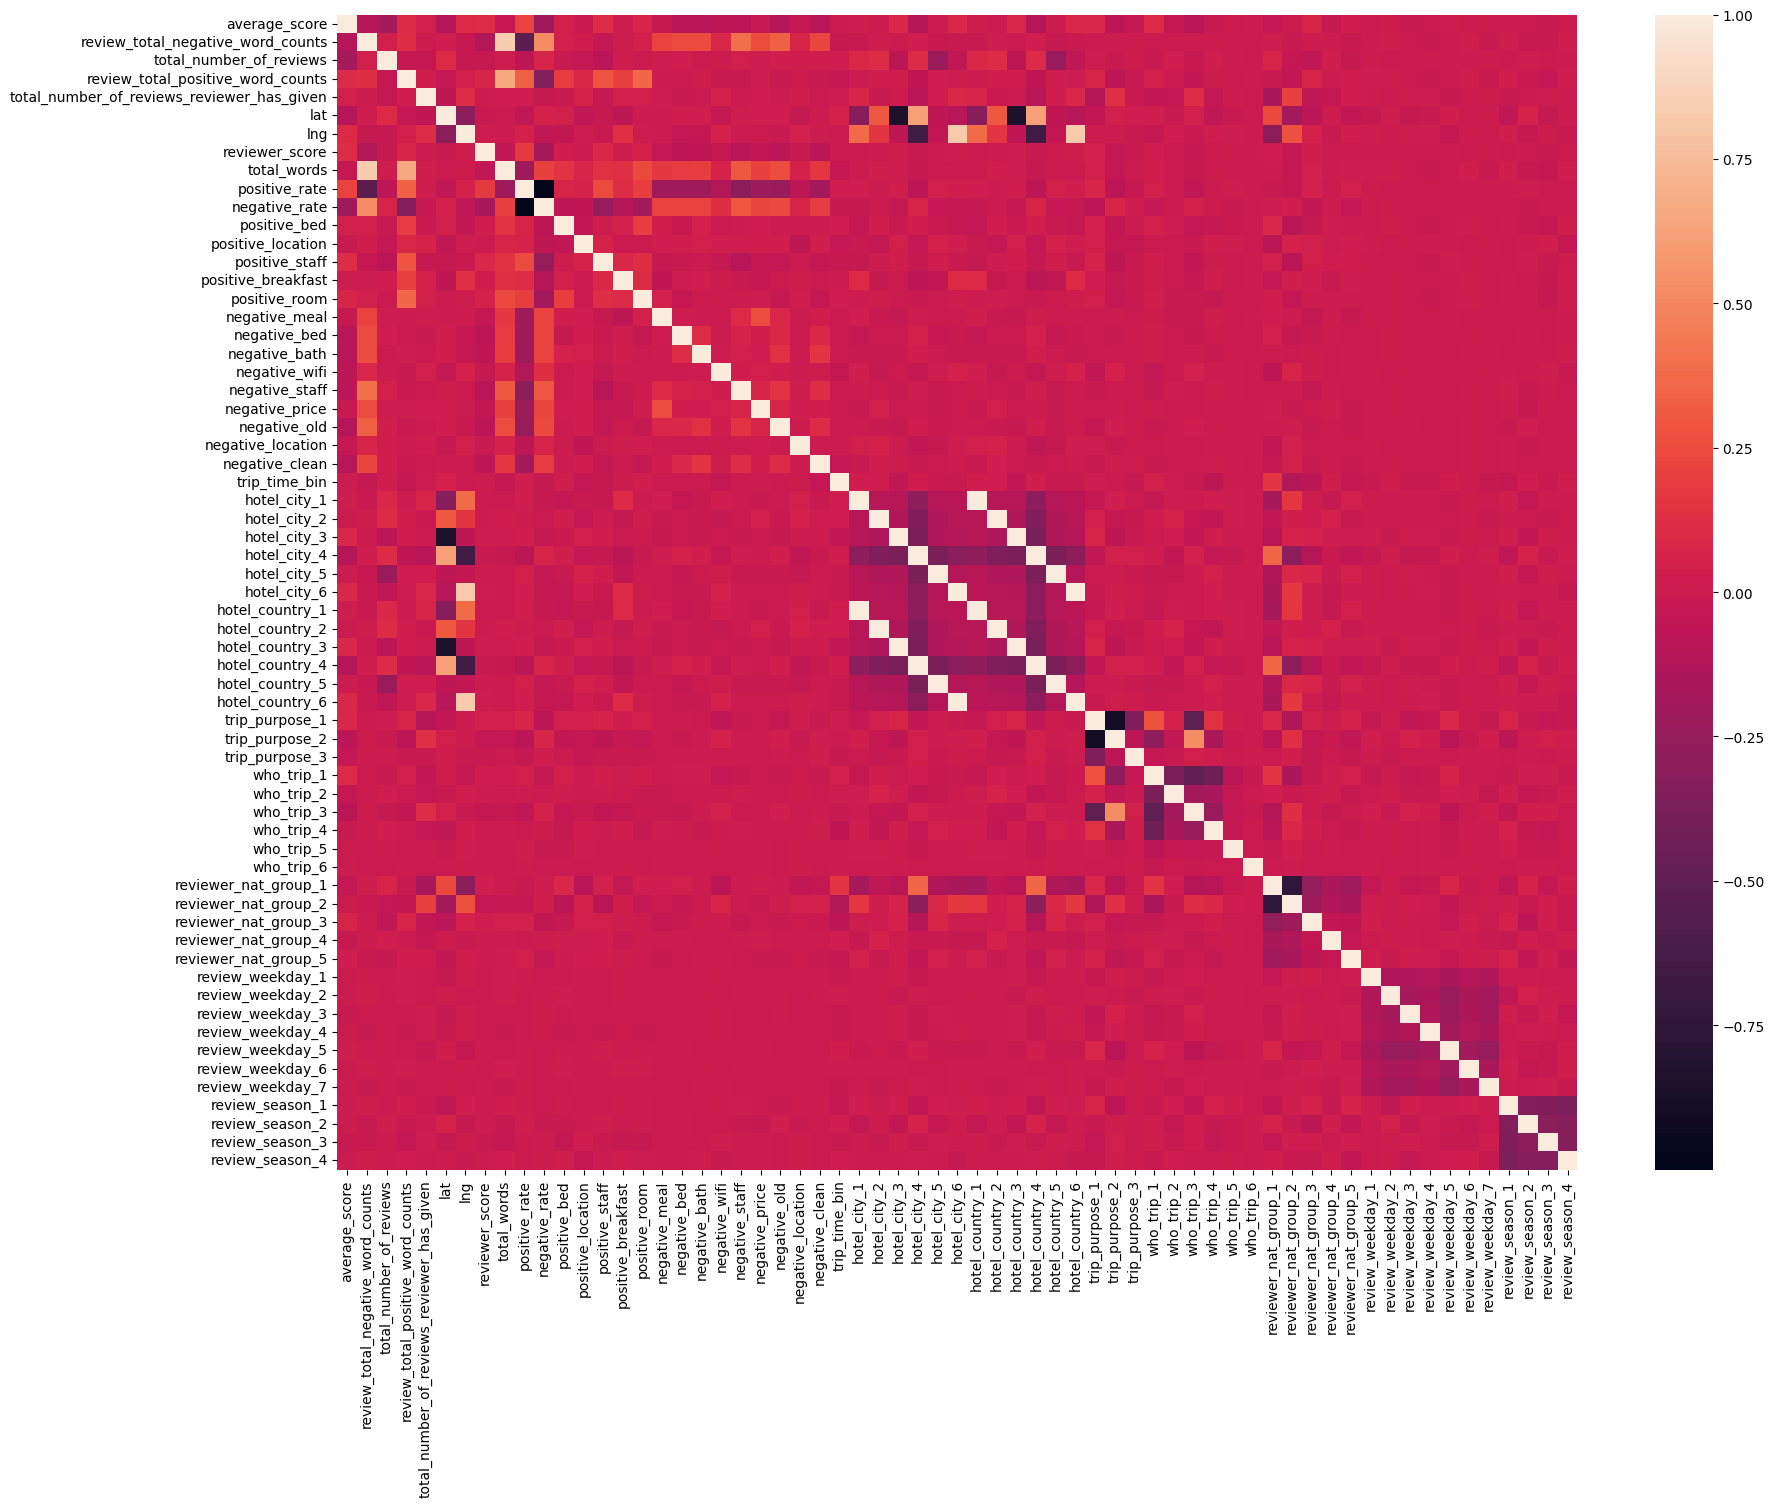

In [337]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(data.drop(['sample'], axis=1).corr())

In [339]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [340]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 64 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   total_words                                 515738 non-null  int64  
 

In [341]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 
           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews', 'total_words',
            'positive_rate', 'negative_rate'
           ]
# категориальные признаки
# множество всех признаков - мн-во непрерывных - флаг 'sample' для разделения выборок
cat_cols = list(set(data.columns) - set(num_cols) - {'reviewer_score', 'sample'})

# преобразуем значения категориальных признаков в целые числа
for col in cat_cols:
    X[col] = X[col].astype(int)

<AxesSubplot: >

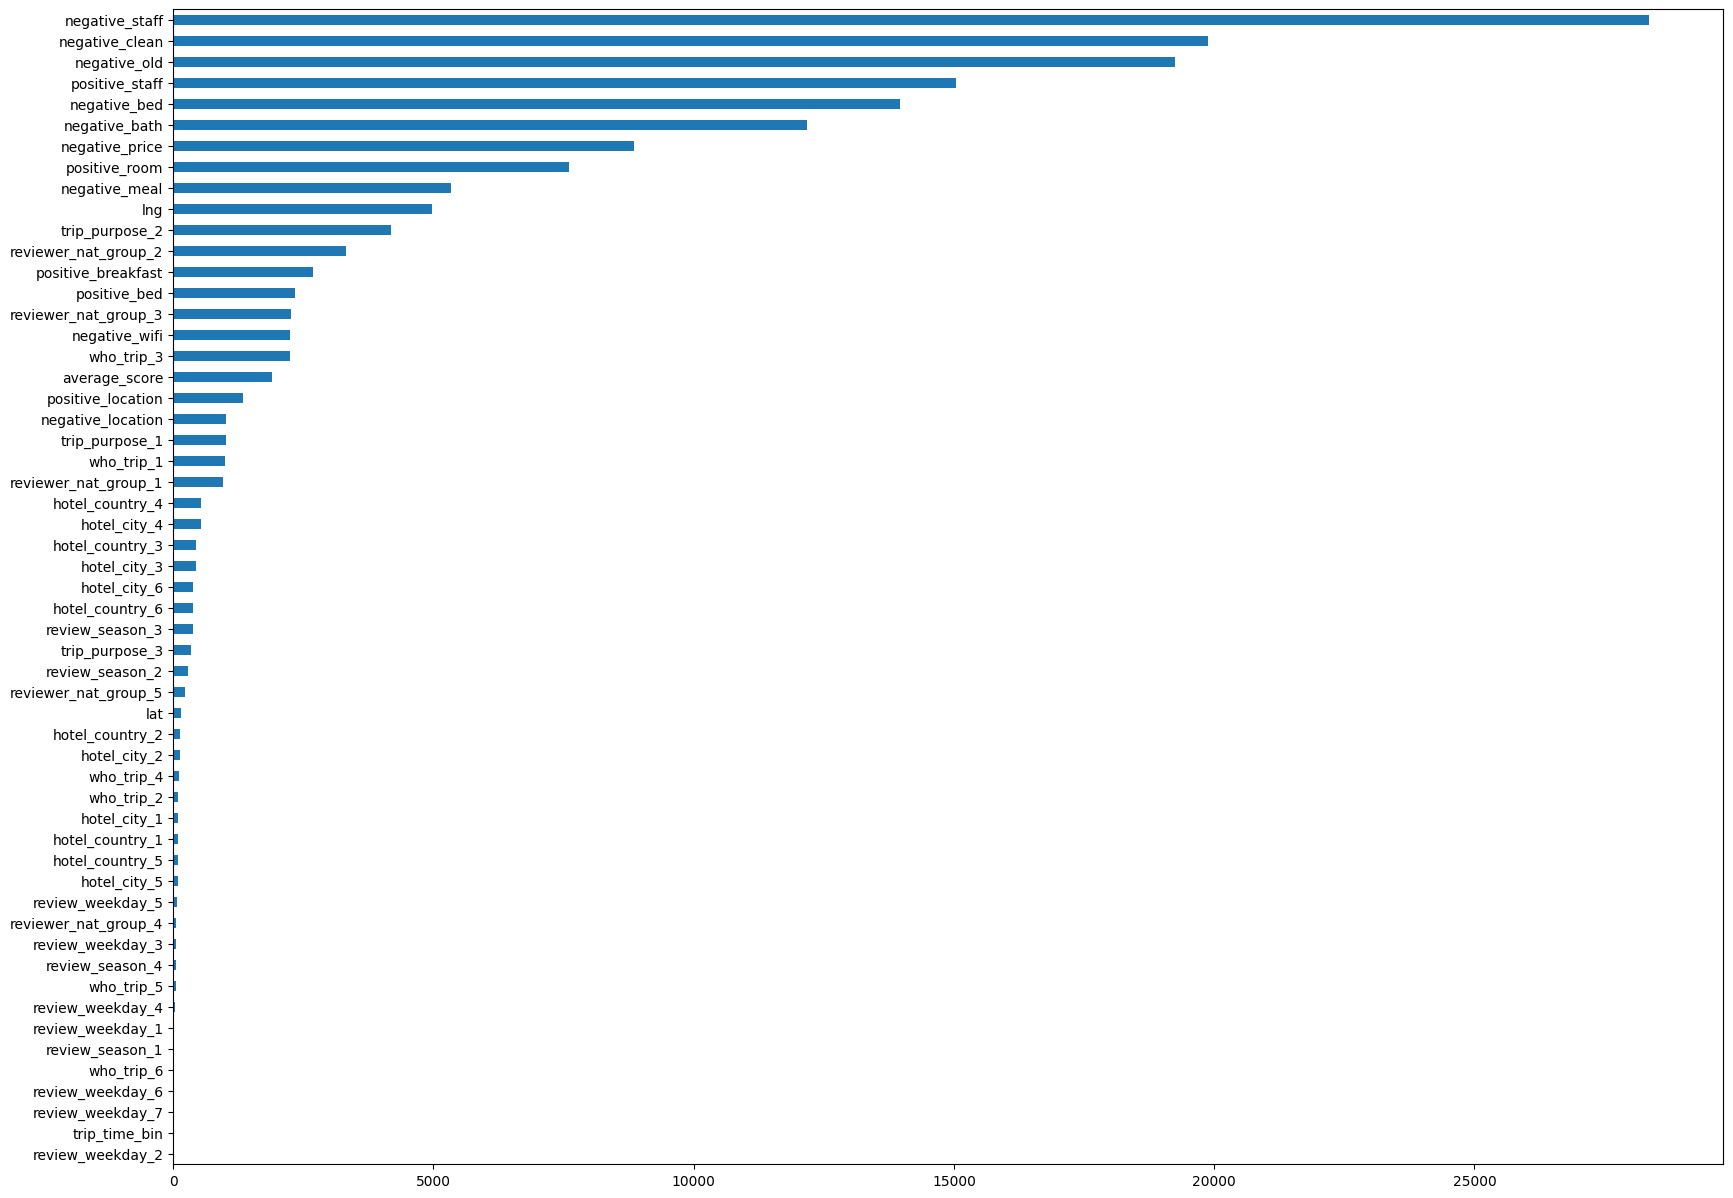

In [342]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


<AxesSubplot: >

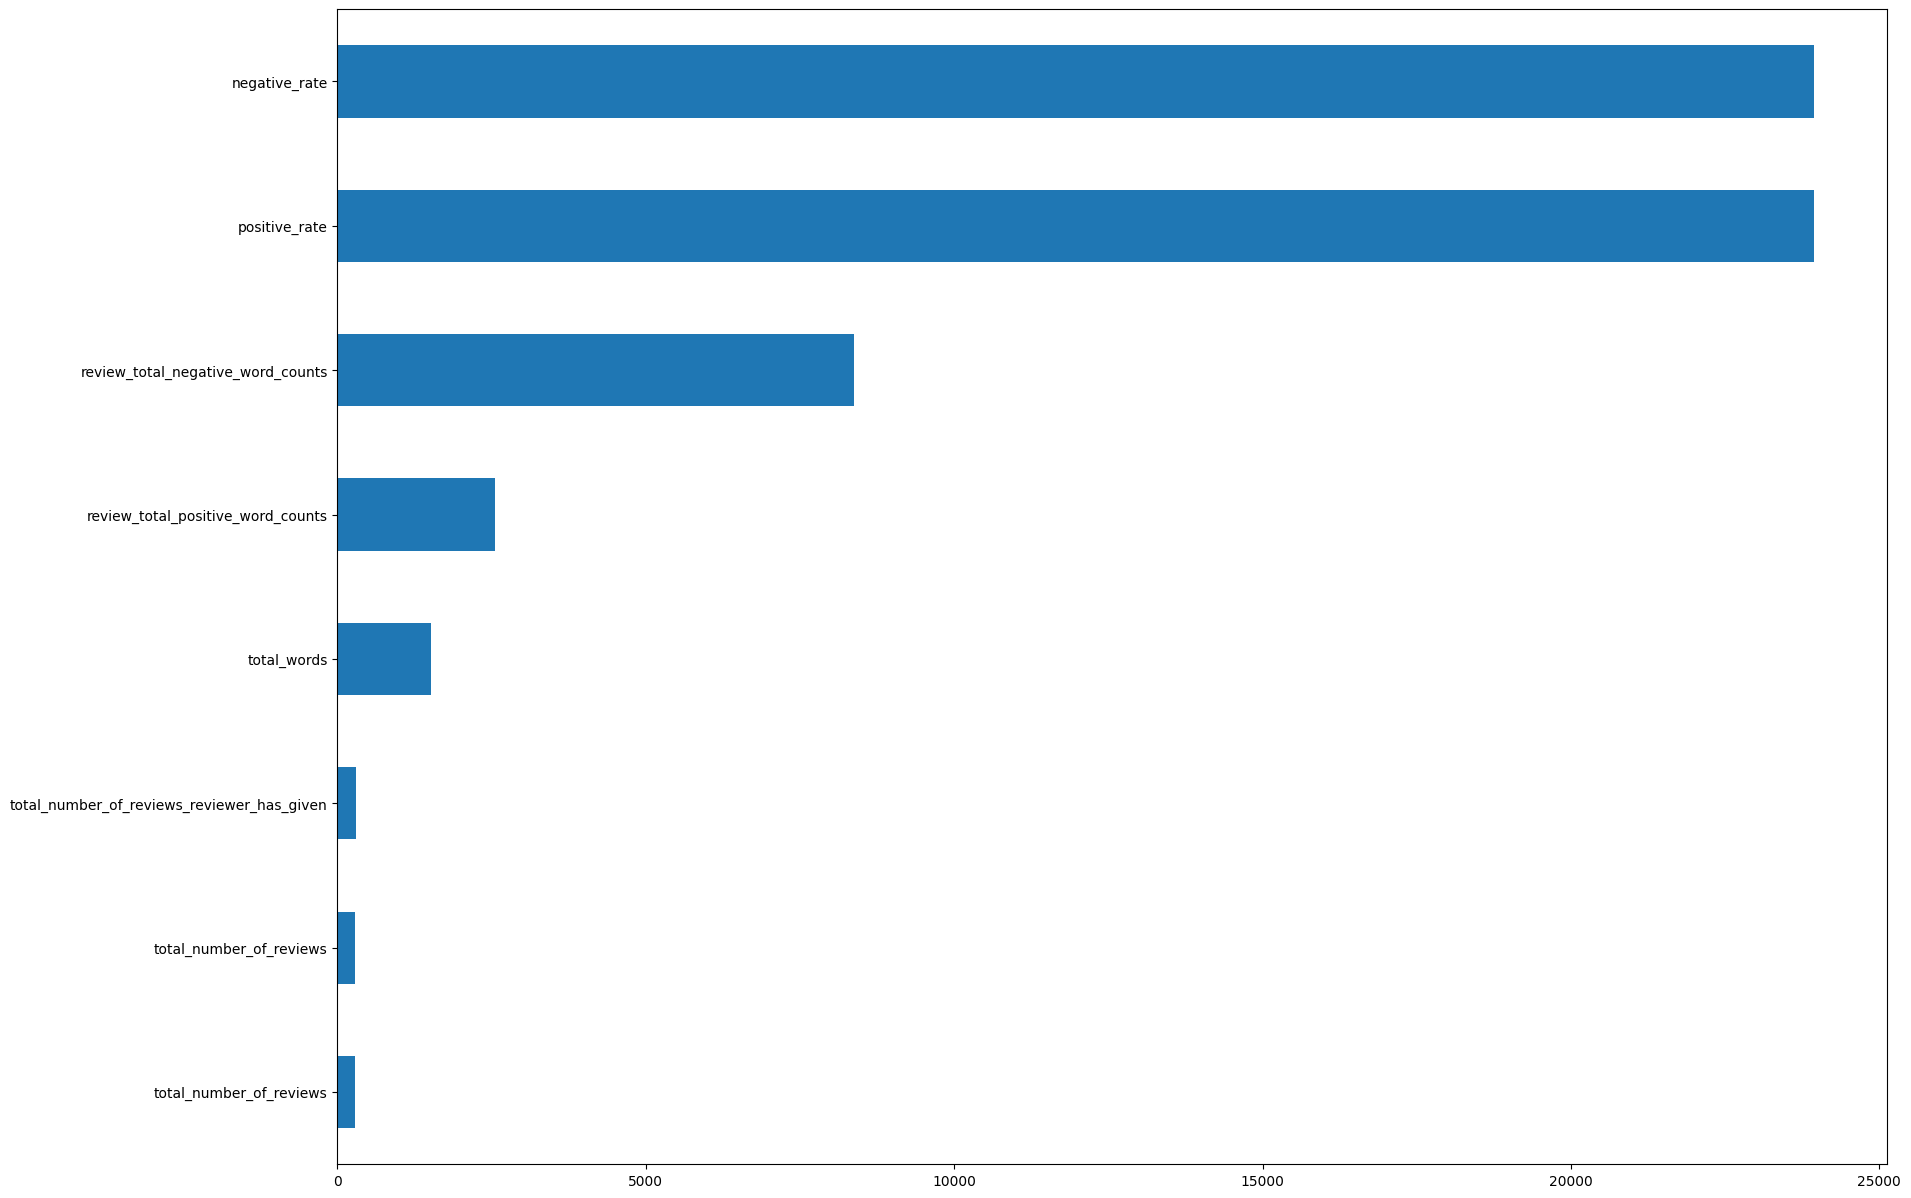

In [343]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### 2.4.1 Удаление признаков, слабо влияющих на целевую переменную

In [344]:
final_features = ['negative_staff', 'negative_clean', 'negative_old', 'positive_staff',
                   'negative_bed', 'negative_bath', 'negative_price', 'positive_room',
                   'negative_meal', 'lng', # категориальные признаки значение более 5000, которые оставляем
                  'positive_rate', 'review_total_negative_word_counts', # и непрерывные
                  'trip_purpose_2', 'reviewer_nat_group_2', 'positive_breakfast', 'positive_bed', 'reviewer_nat_group_3',
                  'negative_wifi', 'who_trip_3', 'average_score', 'positive_location', 'negative_location', 'trip_purpose_1',
                  'who_trip_1', 'reviewer_nat_group_1', 'hotel_country_4', 'hotel_city_4', 'hotel_country_3', 'hotel_city_3',
                  'hotel_city_6', 'hotel_country_6', 'positive_rate'
                 ]
features_to_drop = list(set(X.columns) - set(final_features)) # признаки, подлежащие удалению

X = X.drop(features_to_drop, axis=1)
X

,average_score,review_total_negative_word_counts,lng,positive_rate,positive_bed,positive_location,positive_staff,positive_breakfast,positive_room,negative_meal,...,hotel_country_3,hotel_country_4,hotel_country_6,trip_purpose_1,trip_purpose_2,who_trip_1,who_trip_3,reviewer_nat_group_1,reviewer_nat_group_2,reviewer_nat_group_3
128935,8,3,0,57.0,0,0,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0
128936,8,3,0,40.0,0,1,0,0,0,1,...,0,1,0,0,1,1,0,1,0,0
128937,8,6,2,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
128938,7,0,2,100.0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,1,0,0
128939,8,4,4,83.0,0,0,1,1,1,0,...,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9,0,0,100.0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
515734,8,0,16,100.0,1,0,0,0,1,0,...,0,0,1,1,0,1,0,0,1,0
515735,6,12,0,43.0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
515736,8,0,0,100.0,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0


# 3. Обучение модели

In [345]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [346]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 63), (386803, 63), (386803, 31), (309442, 31), (77361, 31))

In [347]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [349]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [350]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


In [351]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 1.0557109867333272


<AxesSubplot: >

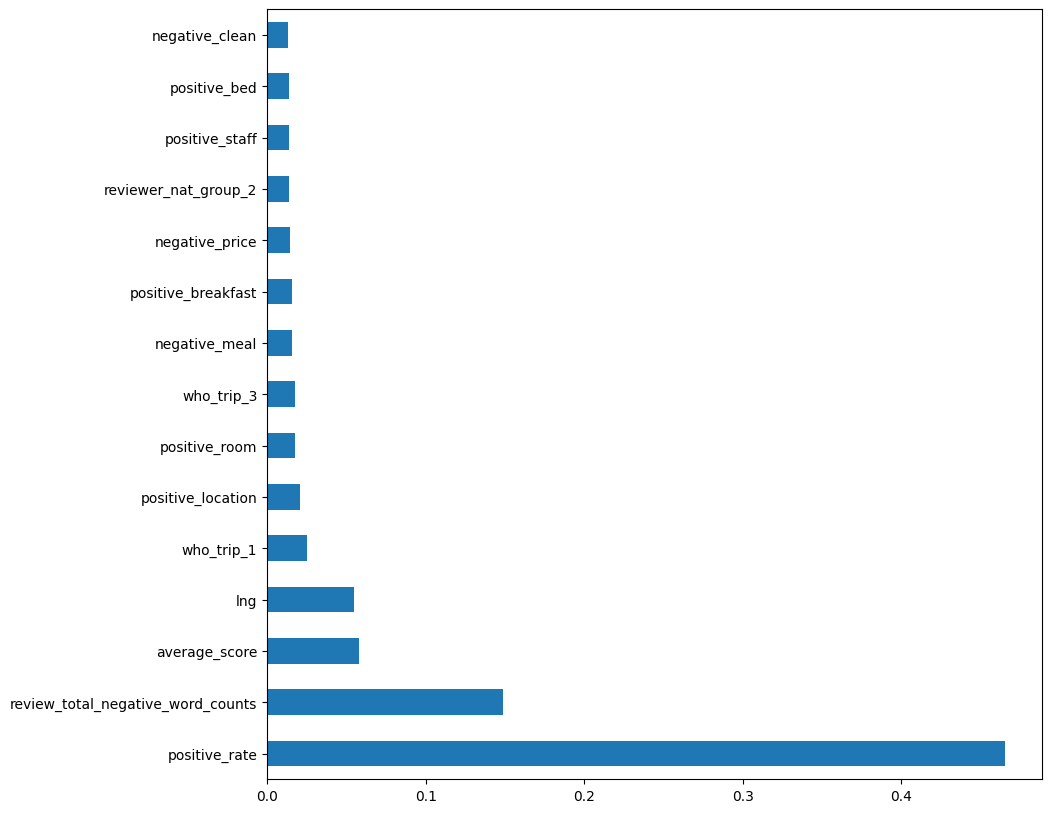

In [137]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [138]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,total_words,positive_rate,...,review_weekday_2,review_weekday_3,review_weekday_4,review_weekday_5,review_weekday_6,review_weekday_7,review_season_1,review_season_2,review_season_3,review_season_4
118350,9.3,6,1276,18,1,51.517876,-0.144065,0.0,24,75.0,...,0,0,0,1,0,0,0,0,0,1
34225,8.2,0,762,4,16,48.875651,2.304157,0.0,4,100.0,...,1,0,0,0,0,0,0,1,0,0
98082,8.6,16,5018,4,11,52.385649,4.834443,0.0,20,20.0,...,0,0,0,1,0,0,0,0,0,1
2127,8.4,4,3274,4,7,51.495666,-0.145279,0.0,8,50.0,...,1,0,0,0,0,0,0,1,0,0
16280,9.1,3,1543,34,1,45.479888,9.196298,0.0,37,92.0,...,0,0,0,0,1,0,1,0,0,0
79431,8.7,27,5236,27,1,52.357655,4.844576,0.0,54,50.0,...,1,0,0,0,0,0,0,0,0,1
56871,8.7,17,2485,7,1,51.493873,-0.182496,0.0,24,29.0,...,0,0,0,0,0,1,0,0,1,0
99357,8.1,33,7105,13,26,51.499046,-0.191707,0.0,46,28.0,...,0,0,1,0,0,0,0,1,0,0
90450,7.8,6,392,5,90,45.506502,9.196519,0.0,11,45.0,...,0,0,1,0,0,0,1,0,0,0
61576,8.2,13,988,4,1,45.486203,9.200322,0.0,17,24.0,...,1,0,0,0,0,0,0,1,0,0


In [139]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [140]:
test_data = test_data.drop(features_to_drop, axis = 1)

In [141]:
test_data

,average_score,review_total_negative_word_counts,lng,positive_rate,positive_bed,positive_location,positive_staff,positive_breakfast,positive_room,negative_meal,...,negative_price,negative_old,negative_location,negative_clean,trip_purpose_1,trip_purpose_2,who_trip_1,who_trip_3,reviewer_nat_group_2,reviewer_nat_group_3
0,8.1,52,9.171102,54.0,0,0,1,1,1,0,...,1,1,0,0,1,0,1,0,0,0
1,8.6,10,4.834443,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,8.3,3,2.161520,62.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
3,9.1,0,9.196298,100.0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
4,9.1,0,4.888644,100.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,8.1,0,9.221836,100.0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0
128931,7.8,0,2.178663,100.0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
128932,8.0,31,16.366915,43.0,0,1,1,0,1,1,...,0,0,0,0,0,1,0,1,1,0
128933,9.0,0,9.207380,100.0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [142]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [143]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


In [144]:
predict_submission

array([8.48      , 9.0067381 , 8.70722799, ..., 8.18      , 9.94833333,
       9.03384091])

In [145]:
list(sample_submission)

['reviewer_score', 'id']

In [146]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

PermissionError: [Errno 13] Permission denied: 'submission.csv'